## Introduction:

The goal of this notebook is to better understand the victims of police killings in the first 5 months of 2015. The United State has much higher rates of police killings than comparable Western first world contries (see: https://www.theguardian.com/us-news/2015/jun/09/the-counted-police-killings-us-vs-other-countries). These comparably higher killing rates begs the questions who is targeted and how likely is this to affect your life?

This notebook has a specific focus on race and ethnicity and will explore how that variable changes the likelihood of being a victim of police killings. To better understand the how police killings effect different racial groups, United States Census data will be used. This data is not always from 2015 and will be used as a way to estimate what racial groups are more affected than others.

Please also note that I am using the language specified by the data when refering to race and gender, I do not believe all racial groups and gender identities fall into the categories provided.

In [1]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from scipy import stats
from scipy.stats.distributions import beta
from scipy.special import beta as beta_func

import pymc3 as pm

import pandas as pd

import datetime

import seaborn as sns

import folium
from folium.plugins import MarkerCluster

from IPython.display import HTML

plt.style.use('bmh')

In [2]:
data = pd.read_csv('police_killings.csv', encoding = "ISO-8859-1")

In [3]:
data

,name,age,gender,raceethnicity,month,day,year,streetaddress,city,state,...,share_hispanic,p_income,h_income,county_income,comp_income,county_bucket,nat_bucket,pov,urate,college
0,A'donte Washington,16,Male,Black,February,23,2015,Clearview Ln,Millbrook,AL,...,5.6,28375,51367.0,54766,0.937936,3.0,3.0,14.1,0.097686,0.168510
1,Aaron Rutledge,27,Male,White,April,2,2015,300 block Iris Park Dr,Pineville,LA,...,0.5,14678,27972.0,40930,0.683411,2.0,1.0,28.8,0.065724,0.111402
2,Aaron Siler,26,Male,White,March,14,2015,22nd Ave and 56th St,Kenosha,WI,...,16.8,25286,45365.0,54930,0.825869,2.0,3.0,14.6,0.166293,0.147312
3,Aaron Valdez,25,Male,Hispanic/Latino,March,11,2015,3000 Seminole Ave,South Gate,CA,...,98.8,17194,48295.0,55909,0.863814,3.0,3.0,11.7,0.124827,0.050133
4,Adam Jovicic,29,Male,White,March,19,2015,364 Hiwood Ave,Munroe Falls,OH,...,1.7,33954,68785.0,49669,1.384868,5.0,4.0,1.9,0.063550,0.403954
5,Adam Reinhart,29,Male,White,March,7,2015,18th St and Palm Ln,Phoenix,AZ,...,79,15523,20833.0,53596,0.388704,1.0,1.0,58,0.073651,0.102955
6,Adrian Hernandez,22,Male,Hispanic/Latino,March,27,2015,4000 Union Ave,Bakersfield,CA,...,44.2,25949,58068.0,48552,1.195996,4.0,4.0,17.2,0.131461,0.203801
7,Adrian Solis,35,Male,Hispanic/Latino,March,26,2015,1500 Bayview Ave,Wilmington,CA,...,84.1,25043,66543.0,55909,1.190202,4.0,4.0,12.2,0.094347,0.090438
8,Alan Alverson,44,Male,White,January,28,2015,Pickett Runn Rd,Sunset,TX,...,66.3,16778,30391.0,38310,0.793292,2.0,1.0,37.7,0.140833,0.047601
9,Alan James,31,Male,White,February,7,2015,200 Abbie St SE,Wyoming,MI,...,26.5,22005,44553.0,51667,0.862311,3.0,2.0,18.4,0.174167,0.102692


In [4]:
months = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
          'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11,
          'December': 12}

race = {'Black': 1, 'White':2, 'Hispanic/Latino':3, 'Native American':4, 'Unknown': 5}

In [5]:
locations = []

names = []

state = []

dates = []
black_dates = []
white_dates = []
hispanic_dates =[]
native_dates = []
unknown_dates = []
asian_pacific_dates = []

black_income = []
white_income = []
hispanic_income =[]
native_income = []
unknown_income = []
asian_pacific_income = []

black_women = 0
white_women = 0
hispanic_women = 0
native_women = 0
asian_pacific_women = 0

black_unarmed = 0
white_unarmed = 0
hispanic_unarmed = 0
native_unarmed = 0
asian_pacific_unarmed = 0


for i in range(len(data['day'])):    
    names.append(data['name'][i])
    
    state.append(data['state'][i])
    
    locations.append([data['latitude'][i], data['longitude'][i]])
    
    dates.append(datetime.datetime(data['year'][i], months[data['month'][i]], data['day'][i]))
    
    if data['raceethnicity'][i] == 'Black':
        black_dates.append(datetime.datetime(data['year'][i], months[data['month'][i]], data['day'][i]))
        black_income.append(data['p_income'][i])
        if data['gender'][i] == 'Female':
            black_women += 1
        if data['armed'][i] == 'No':
            black_unarmed += 1
        
    elif data['raceethnicity'][i] == 'White':
        white_dates.append(datetime.datetime(data['year'][i], months[data['month'][i]], data['day'][i]))
        white_income.append(data['p_income'][i])
        if data['gender'][i] == 'Female':
            white_women += 1
        if data['armed'][i] == 'No':
            white_unarmed += 1
        
    elif data['raceethnicity'][i] == 'Hispanic/Latino':
        hispanic_dates.append(datetime.datetime(data['year'][i], months[data['month'][i]], data['day'][i]))
        hispanic_income.append(data['p_income'][i])
        if data['gender'][i] == 'Female':
            hispanic_women += 1
        if data['armed'][i] == 'No':
            hispanic_unarmed += 1
        
    elif data['raceethnicity'][i] == 'Native American':
        native_dates.append(datetime.datetime(data['year'][i], months[data['month'][i]], data['day'][i]))
        native_income.append(data['p_income'][i])
        if data['gender'][i] == 'Female':
            native_women += 1
        if data['armed'][i] == 'No':
            native_unarmed += 1
        
    elif data['raceethnicity'][i] == 'Asian/Pacific Islander':
        asian_pacific_dates.append(datetime.datetime(data['year'][i], months[data['month'][i]], data['day'][i]))
        asian_pacific_income.append(data['p_income'][i])
        if data['gender'][i] == 'Female':
            asian_pacific_women += 1
        if data['armed'][i] == 'No':
            asian_pacific_unarmed += 1
        
    elif data['raceethnicity'][i] == 'Unknown':
        unknown_dates.append(datetime.datetime(data['year'][i], months[data['month'][i]], data['day'][i]))
        unknown_income.append(data['p_income'][i])

# personal income by race
black_income = [int(i) for i in black_income if i != '-']
white_income = [int(i) for i in white_income if i != '-']
hispanic_income = [int(i) for i in hispanic_income if i != '-']
native_income = [int(i) for i in native_income if i != '-']
unknown_income = [int(i) for i in unknown_income if i != '-']
asian_pacific_income = [int(i) for i in asian_pacific_income if i != '-']

In [6]:
mpl_dates = mdates.date2num(dates)
mpl_black_dates = mdates.date2num(black_dates)
mpl_white_dates = mdates.date2num(white_dates)
mpl_hispanic_dates = mdates.date2num(hispanic_dates)
mpl_native_dates = mdates.date2num(native_dates)
mpl_asian_pacific_dates = mdates.date2num(asian_pacific_dates)
mpl_unknown_dates = mdates.date2num(unknown_dates)

## Analysis:

First we'll examine police killings over the given time frame. We don't have data from a long enough time frame to look for an overall trend but we can see that there appears to be some uniformity in the number of killings over time. This is somewhat unsurprising as one wouldn't expect time of year to greatly impact the number police killings in the United States.

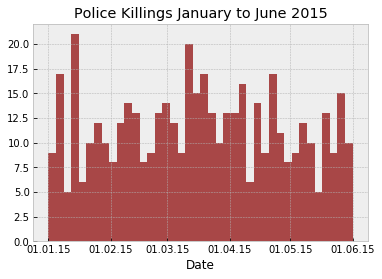

In [7]:
fig, ax = plt.subplots(1,1)
plt.title('Police Killings January to June 2015')
plt.xlabel('Date')
ax.hist(mpl_dates, bins=40, color='darkred', alpha = .7)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
plt.show()

By breaking down the number of killings over time by race, we can see that the general uniformity of the distribution continues.

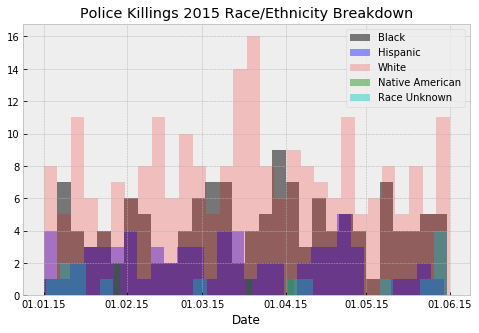

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
plt.title('Police Killings 2015 Race/Ethnicity Breakdown')
plt.xlabel('Date')
ax.hist(mpl_black_dates, bins=30, color='k', alpha = .5, label='Black')
ax.hist(mpl_hispanic_dates, bins=30, color='b', alpha = .4, label = 'Hispanic')
ax.hist(mpl_white_dates, bins=30, color='r', alpha = .2, label='White')
ax.hist(mpl_native_dates, bins=30, color='g', alpha = .4, label='Native American')
ax.hist(mpl_unknown_dates, bins=30, color='c', alpha = .4, label='Race Unknown')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
plt.legend()
plt.show()

In [9]:
# These population percent numbers have been pulled from wikipedia.

white_percent = 0.733
black_percent = 0.216
native_percent = 0.008
asian_pacific_percent = 0.054


# These population numbers have been pulled from wikipedia.

white_pop = 233657078
black_pop = 40241818
native_pop = 2597817
asian_pacific_pop = 16614625 + 560021

black_total = len(black_dates)
white_total = len(white_dates)
hispanic_total = len(hispanic_dates)
native_total = len(native_dates) 
asian_pacific_total = len(asian_pacific_dates)
unknown_total = len(unknown_dates)

Here, we can see the racial break down of victims. There are a notable number of Black, White, and Hispanic killings.

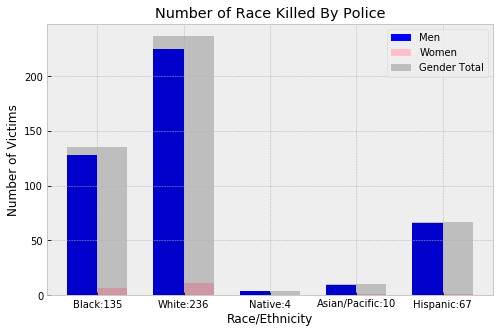

In [10]:
n_groups = 5

both_totals = [(black_total), (white_total), (native_total), (asian_pacific_total), hispanic_total]

men_totals = [(black_total - black_women), (white_total - white_women) ,
                    (native_total - native_women) , (asian_pacific_total- asian_pacific_women) , 
                (hispanic_total - hispanic_women)]

women_totals = [(black_women), (white_women), (native_women) , (asian_pacific_women) , hispanic_women]

fig, ax = plt.subplots(figsize=(8,5))

index = np.arange(n_groups)
bar_width = 0.35

opacity = 1

rects1 = ax.bar(index, men_totals, bar_width, alpha=opacity, color='b', label='Men')

rects2 = ax.bar(index + bar_width, women_totals, bar_width,
                alpha=opacity, color='pink',
                label='Women')

rects3 = ax.bar(index + (.5*bar_width), both_totals, 2 * bar_width,
                alpha=0.2, color='k',
                label='Gender Total')

ax.set_xlabel('Race/Ethnicity')
ax.set_ylabel('Number of Victims')
ax.set_title('Number of Race Killed By Police')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('{}{}'.format('Black:',black_total), 
                   '{}{}'.format('White:',white_total), 
                   '{}{}'.format('Native:',native_total), 
                   '{}{}'.format('Asian/Pacific:',asian_pacific_total), 
                   '{}{}'.format('Hispanic:',hispanic_total)))
ax.legend()

plt.show()

Looking at the previous histogram, it is apparent that more White people have been killed by police than any other race. This makes sense given the large percent of Americans who identify as White. To see which racial group is most likely to be a victim of a police shooting we can divide the total number of victims of each racial group by the the total number of people in that racial group. Using 2010 census data pulled from Wikipedia, we can see which racial groups are most frequently victims. The census does not treat the hispanic racial group as a separate racial group so we'll only look at White, Black, Native American, and Asian racial groups.

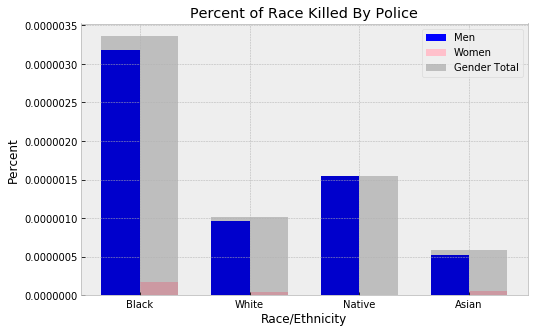

In [11]:
n_groups = 4

both_percents = ((black_total) / black_pop, (white_total) / white_pop,
            (native_total) / native_pop, 
            (asian_pacific_total) / asian_pacific_pop)

men_percents = ((black_total - black_women) / black_pop, (white_total - white_women) / white_pop,
            (native_total - native_women) / native_pop, 
            (asian_pacific_total- asian_pacific_women) / asian_pacific_pop)

women_percents = ((black_women) / black_pop, (white_women) / white_pop,
            (native_women) / native_pop, (asian_pacific_women) / asian_pacific_pop)

fig, ax = plt.subplots(figsize=(8,5))

index = np.arange(n_groups)
bar_width = 0.35

opacity = 1

rects1 = ax.bar(index, men_percents, bar_width,
                alpha=opacity, color='b',
                label='Men')

rects2 = ax.bar(index + bar_width, women_percents, bar_width,
                alpha=opacity, color='pink',
                label='Women')

rects3 = ax.bar(index + (.5*bar_width), both_percents, 2 * bar_width,
                alpha=0.2, color='k',
                label='Gender Total')

ax.set_xlabel('Race/Ethnicity')
ax.set_ylabel('Percent')
ax.set_title('Percent of Race Killed By Police')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Black', 'White', 'Native', 'Asian'))
ax.legend()

plt.show()

Based on the data, we can see that any given Black male in 2015 was more than 3 times more likely to be killed by police than a given White male. These numbers support arguments that there are racial biases when police interact with Americans. This data also shows the vast gender discrepancy across all racial groups; males are much more likely to be victims of police killings.

In [12]:
black_unarmed_percent = black_unarmed/black_total
white_unarmed_percent = white_unarmed/white_total
hispanic_unarmed_percent = hispanic_unarmed/hispanic_total
native_unarmed_percent = native_unarmed/native_total
asian_pacific_unarmed_percent = asian_pacific_unarmed/asian_pacific_total

Now, we'll examine the percentage of each racial group killed while unarmed. Here we can see that police killed roughly the same unarmed percentage of each racial group. The Asian/Pacific Islander group is a bit of an outlier given the small number of data points in that racial group.

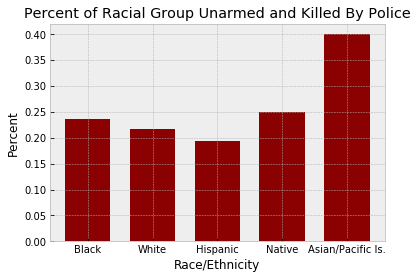

In [13]:
n_groups = 5

unarmed_percent = (black_unarmed_percent, white_unarmed_percent, hispanic_unarmed_percent, 
                   native_unarmed_percent, asian_pacific_unarmed_percent)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 1

rects1 = ax.bar(index + (.5*bar_width), unarmed_percent, 2 * bar_width,
                alpha=1, color='darkred',
                label='Unarmed')

ax.set_xlabel('Race/Ethnicity')
ax.set_ylabel('Percent')
ax.set_title('Percent of Racial Group Unarmed and Killed By Police')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Black', 'White', 'Hispanic', 'Native', 'Asian/Pacific Is.'))

plt.show()

In [14]:
state_count = {}
count = []
top7_states = {}
top7_nums = []


for i in state:
    state_count[i] = state.count(i)

for i in state_count:
    count.append(state_count[i])

top7_nums = sorted(count)[-7:]
top7_nums.reverse()

for i in state_count:
    if state_count[i] in top7_nums:
        top7_states[i] = state_count[i]


Moving on to which states have the most police killings, we can look at the top 7 most killings and also see how the state population affects these numbers. California leads the states in most police killings, but when the large population of the state is factored in, the number of police killings per state citizen is more on par with other states. On the other hand, Oklahoma an Arizona have very high rate of police killings per number of state citizens.

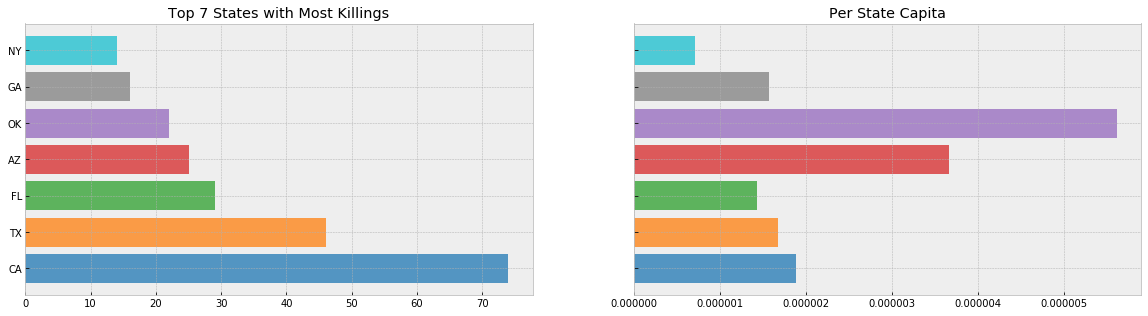

In [15]:
#population estimates from factfinder.census.gov for US states in 2015

ca_pop = 39144818
tx_pop = 27469114
fl_pop = 20271272
az_pop = 6828065
ok_pop = 3911338
ga_pop = 10214860
ny_pop = 19795791

ca_percent = top7_states['CA'] / ca_pop
tx_percent = top7_states['TX'] / tx_pop
fl_percent = top7_states['FL'] / fl_pop
az_percent = top7_states['AZ'] / az_pop
ok_percent = top7_states['OK'] / ok_pop
ga_percent = top7_states['GA'] / ga_pop
ny_percent = top7_states['NY'] / ny_pop

state_percents = [ca_percent,tx_percent,fl_percent,az_percent,ok_percent,ga_percent,ny_percent]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:gray', 'tab:cyan']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,5))
plt.setp(ax1, yticks=range(len(top7_states)), yticklabels=sorted(top7_states, key=top7_states.get, reverse=True))

ax1.barh(range(len(top7_states)), top7_nums, color=colors, alpha=.75)

ax1.set_title('Top 7 States with Most Killings')


ax2.barh(range(len(top7_states)), state_percents, color=colors, alpha=.75)

ax2.set_title('Per State Capita');

The following maps display the location of each killing and the race of the victim.

In [16]:
race = [i for i in data['raceethnicity']]

m = folium.Map(location=[40, -100], tiles='Open Street Map',
                   zoom_start=3, control_scale=True)



marker_cluster = folium.plugins.MarkerCluster().add_to(m)

for index in range(0, len(data)):
    folium.Marker(locations[index], popup= race[index]).add_to(marker_cluster)
m

Since the Black racial group is affected the most per capita, we'll examine where Black people are killed by police. The following map shows the location of each Black person's death and the cause of death. The distribution shows more Black deaths in the southern and eastern areas of the United States.

In [17]:
m = folium.Map(location=[40, -100], tiles='Open Street Map',
                   zoom_start=4, control_scale=True)

marker_cluster = folium.plugins.MarkerCluster().add_to(m)

for index in range(0, len(data)):
    if data['raceethnicity'][index] == 'Black':
        folium.Marker(locations[index], popup= data['cause'][index]).add_to(marker_cluster)
m

The following correlation matrix could potentially reveal correlations between unlikely numeric variables. Although, there aren't many surprising results here.

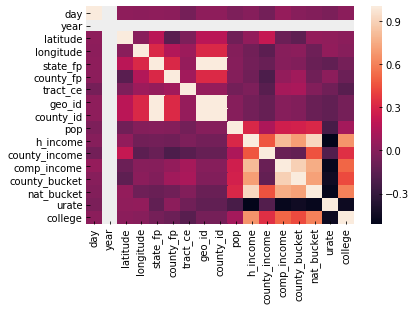

In [18]:
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

Next, we'll examine how the average age of victims compares with the average life expectancy. While the life expectancy present here doesn't take into account specific information like race, gender, income, or education, when compared with the group involved in the data set, that is, the data set is predominantly male, but this life expectancy is based on both genders in the United States. Regardless, the gap between the average age of death of these victims and the average life expectancy is significant.

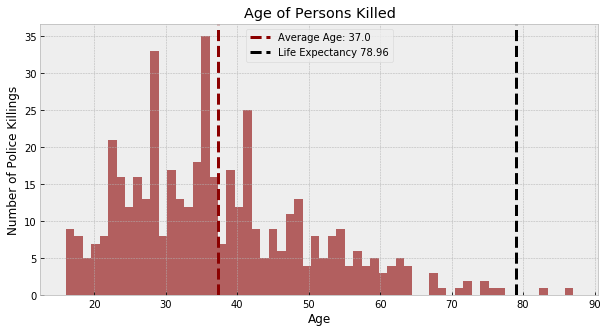

In [19]:
life_expectancy = 78.96

plt.figure(figsize=(10,5))
age = [int(i) for i in data['age'] if i != 'Unknown']
plt.hist(age, color = 'darkred', bins=len(set(age)), alpha = .6)
plt.xlabel('Age')
plt.ylabel('Number of Police Killings')
plt.axvline(np.mean(age), color='darkred', linestyle='dashed', alpha=1,
            linewidth=3, label='{}{}'.format('Average Age: ',round(np.mean(age))))
plt.axvline(life_expectancy, color='k', linestyle='dashed', alpha=1,
            linewidth=3, label='{}{}'.format('Life Expectancy ',life_expectancy))
plt.title('Age of Persons Killed')
plt.legend();

Next we'll begin exploring the economic status of the victims.

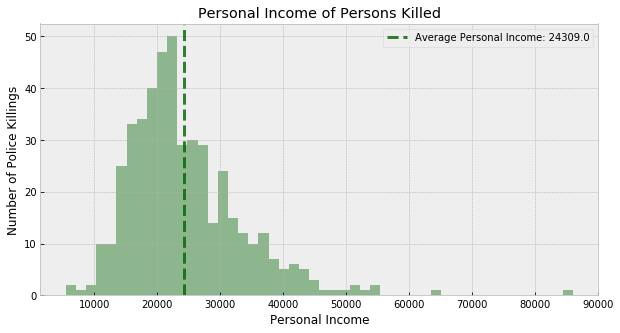

In [20]:
plt.figure(figsize=(10,5))
income0 = [float(i) for i in data['p_income'] if i != '-']
plt.hist(income0, alpha=.4, color = 'darkgreen', bins=50)
plt.axvline(np.mean(income0), color='darkgreen', linestyle='dashed', alpha=.8,
            linewidth=3, label='{}{}'.format('Average Personal Income: ',round(np.mean(income0))))
plt.xlabel('Personal Income')
plt.ylabel('Number of Police Killings')
plt.title('Personal Income of Persons Killed')
plt.legend();

Here we can see the median household income level of the victims is below the national median income.

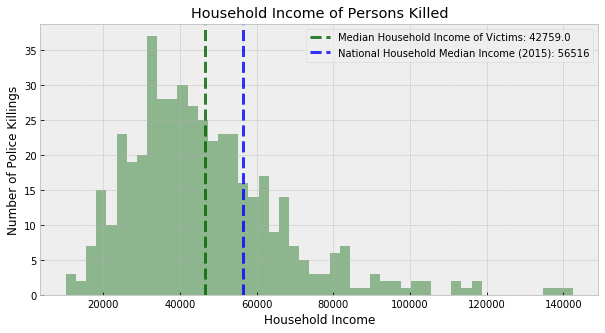

In [21]:
national_median_h_income = 56516

plt.figure(figsize=(10,5))
income1 = [int(i) for i in data['h_income'] if len(str(i)) > 3]
plt.hist(income1, alpha=.4, color = 'darkgreen', bins=50)
plt.axvline(np.mean(income1), color='darkgreen', linestyle='dashed', alpha=.8,
            linewidth=3, label='{}{}'.format('Median Household Income of Victims: ',round(np.median(income1))))
plt.axvline(national_median_h_income, color='b', linestyle='dashed', alpha=.8,
            linewidth=3, label='{}{}'.format('National Household Median Income (2015): ',national_median_h_income))
plt.xlabel('Household Income')
plt.ylabel('Number of Police Killings')
plt.title('Household Income of Persons Killed')
plt.legend();

We can also see that the average personal income of Black people killed is lower than the total average personal income and that the White average personal income of people killed is higher than that of both the total average and the Black people killed. It is also worth noting that the most personally wealthy people killed are Black and made over $80,000 a year.

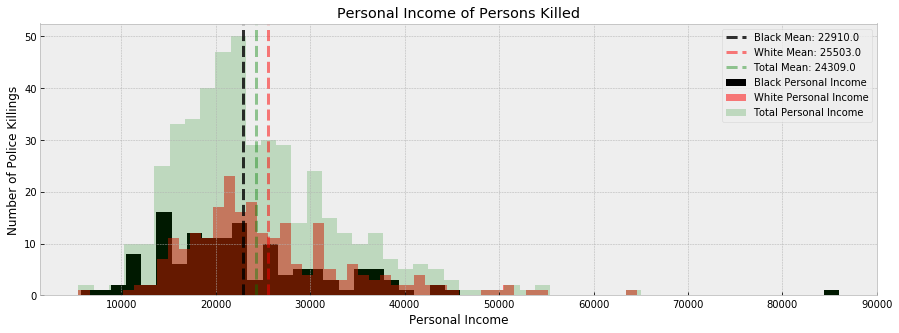

In [22]:
plt.figure(figsize=(15,5))
plt.hist(black_income, alpha=1, color = 'k', bins=50, label='Black Personal Income')
plt.hist(white_income, alpha=.5, color = 'r', bins=50, label='White Personal Income')
plt.hist(income0, alpha=.2, color = 'green', bins=50, label='Total Personal Income')

plt.axvline(np.mean(black_income), color='k', linestyle='dashed', alpha=.8,
            linewidth=3, label=('{}{}'.format('Black Mean: ',round(np.mean(black_income)))))

plt.axvline(np.mean(white_income), color='r', linestyle='dashed', alpha=.5,
            linewidth=3, label=('{}{}'.format('White Mean: ',round(np.mean(white_income)))))

plt.axvline(np.mean(income0), color='green', linestyle='dashed', alpha=.4,
            linewidth=3, label='{}{}'.format('Total Mean: ',round(np.mean(income0))))


plt.xlabel('Personal Income')
plt.ylabel('Number of Police Killings')
plt.title('Personal Income of Persons Killed')
plt.legend();

The "armed" status of the victims helps illuminate the potential threat the victims of police killings presented to police. We can see close to half of the victims were armed with lethal firearms, but a significantly large portion of victims, over 20%, were unarmed and killed.

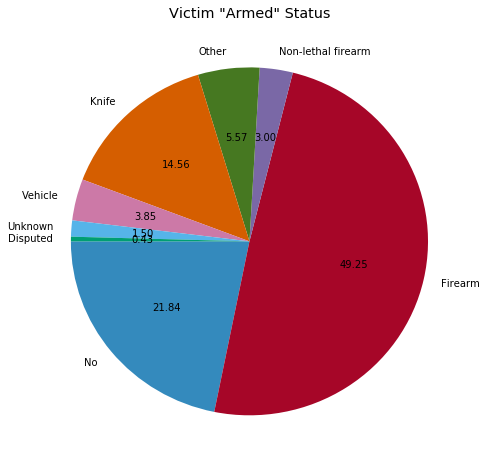

In [23]:
plt.figure(figsize=(8,8))
weapon = [i for i in data['armed']]
weapon_dict = {x:weapon.count(x) for x in weapon}

plt.pie(weapon_dict.values(), labels=weapon_dict.keys(),autopct='%.2f',startangle=180)
plt.title('Victim "Armed" Status');

Since the data set includes the most number of Black and White victims we'll examine how each racial group was affected by their armed status. Here we see the biggest discrepancy in those victims unarmed or armed with a vehicle. More unarmed and driving victims were Black than White.

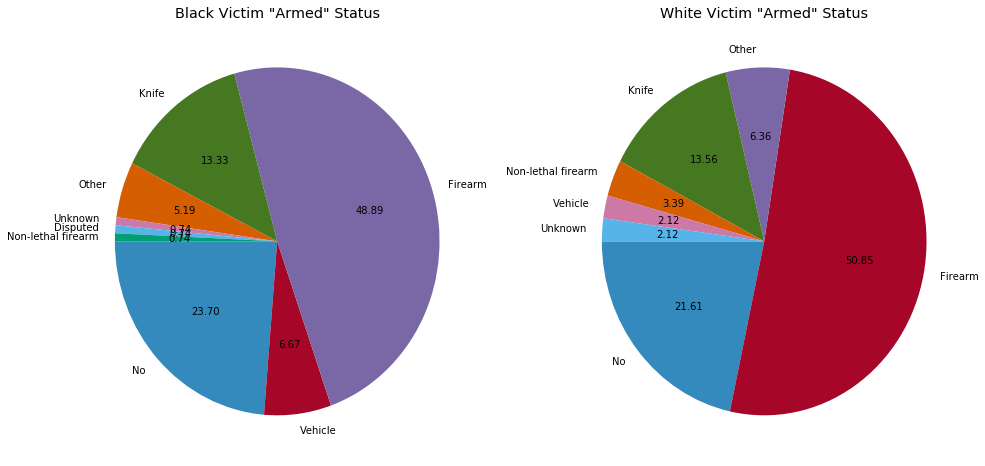

In [24]:
black_weapon = [data['armed'][i] for i in range(len(data['armed'])) if data['raceethnicity'][i] == 'Black']
black_weapon_dict = {x:black_weapon.count(x) for x in black_weapon}

white_weapon = [data['armed'][i] for i in range(len(data['armed'])) if data['raceethnicity'][i] == 'White']
white_weapon_dict = {x:white_weapon.count(x) for x in white_weapon}


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8))

ax1.pie(black_weapon_dict.values(), labels=black_weapon_dict.keys(),autopct='%.2f',startangle=180)
ax1.set_title('Black Victim "Armed" Status');

ax2.pie(white_weapon_dict.values(), labels=white_weapon_dict.keys(),autopct='%.2f',startangle=180)
ax2.set_title('White Victim "Armed" Status');

This reveals the cause of death for all victims. Nearly 90% of victims were killed with guns.

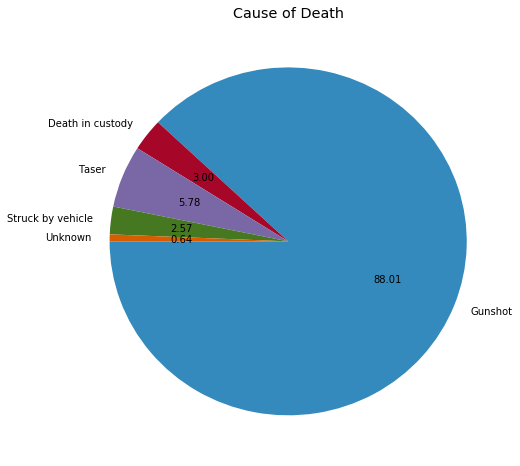

In [25]:
plt.figure(figsize=(8,8))
cause = [i for i in data['cause']]
cause_dict = {x:cause.count(x) for x in cause}

plt.pie(cause_dict.values(), labels=cause_dict.keys(), autopct='%.2f', startangle=180)
plt.title('Cause of Death');

Breaking down this plot by race, specifically Black and White racial groups shows that White people were nearly 10% more likely to be killed by guns and Black people were more likely to be killed by a taser or die in custody.

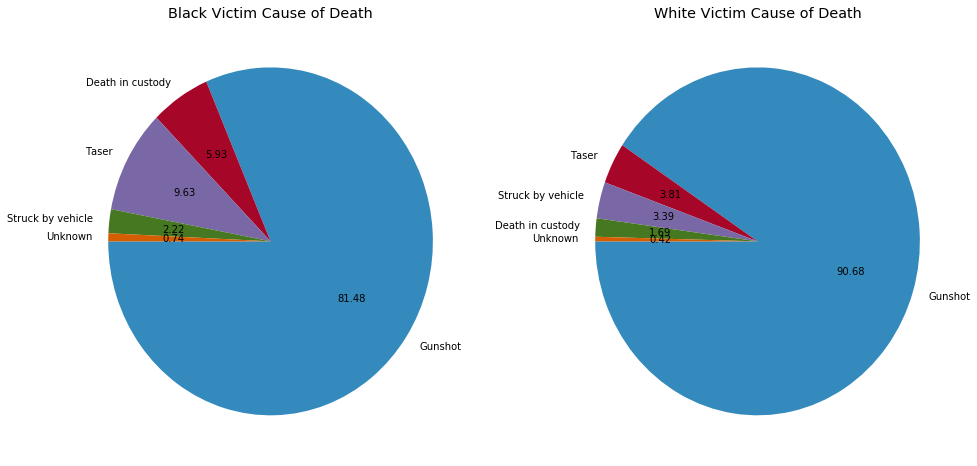

In [26]:
black_cause = [data['cause'][i] for i in range(len(data['cause'])) if data['raceethnicity'][i] == 'Black']
black_cause_dict = {x:black_cause.count(x) for x in black_cause}

white_cause = [data['cause'][i] for i in range(len(data['cause'])) if data['raceethnicity'][i] == 'White']
white_cause_dict = {x:white_cause.count(x) for x in white_cause}


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8))

ax1.pie(black_cause_dict.values(), labels=black_cause_dict.keys(),autopct='%.2f',startangle=180)
ax1.set_title('Black Victim Cause of Death');

ax2.pie(white_cause_dict.values(), labels=white_cause_dict.keys(),autopct='%.2f',startangle=180)
ax2.set_title('White Victim Cause of Death');

## Conclusion:

Based on this data set, we can see that in just five months a significant number of Americans are killed by police and on average 20% of these victims are unarmed. It's also worth noting that these killings disproportionately affect minority groups, specifically Black men. Police violence that results in death undermines the American criminal justice system by exicuting potential criminals before they have access to a fair trial. These numbers help validate claims made by those who feel minority groups are more likely to be victims of police killings. While this data set doesn't capture the United State's full history of police violence, this does offer important information on trends that occur within the five month time frame. One can also speculate that some of these trends continue on into the future and are relavant today.

Also please note that this is my first Kaggle notebook and constructive criticsm is welcome.